In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

### Q1 how many records

In [6]:
df = pd.read_parquet('./data/fhv_tripdata_2021-01.parquet')
df

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037
...,...,...,...,...,...,...,...
1154107,B03266,2021-01-31 23:43:03,2021-01-31 23:51:48,7.0,7.0,None,B03266
1154108,B03284,2021-01-31 23:50:27,2021-02-01 00:48:03,44.0,91.0,None,
1154109,B03285,2021-01-31 23:13:46,2021-01-31 23:29:58,171.0,171.0,None,B03285
1154110,B03285,2021-01-31 23:58:03,2021-02-01 00:17:29,15.0,15.0,None,B03285


In [7]:
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)



### Q2 mean of the duration 

In [8]:
df.describe()


,PUlocationID,DOlocationID,duration
count,195845.000000,991892.000000,1.154112e+06
mean,139.859690,135.898030,1.916722e+01
std,74.991382,80.474902,3.986922e+02
min,1.000000,1.000000,1.666667e-02
25%,75.000000,67.000000,7.766667e+00
50%,143.000000,132.000000,1.340000e+01
75%,206.000000,213.000000,2.228333e+01
max,265.000000,265.000000,4.233710e+05


<AxesSubplot:>

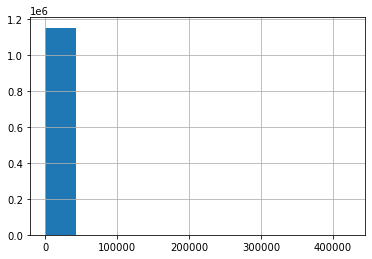

In [9]:
df['duration'].hist()

<AxesSubplot:>

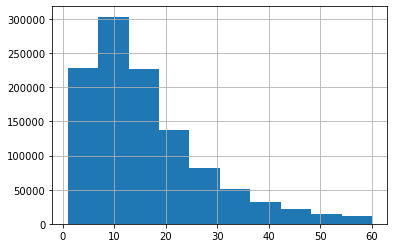

In [10]:
df = df[(df.duration >= 1) & (df.duration <= 60)]
df['duration'].hist()

### Q3 missing values

In [11]:
round(df.isnull().mean()*100,2)

dispatching_base_num        0.00
pickup_datetime             0.00
dropOff_datetime            0.00
PUlocationID               83.53
DOlocationID               13.33
SR_Flag                   100.00
Affiliated_base_number      0.07
duration                    0.00
dtype: float64

In [12]:
df.fillna(-1, inplace=True)
features = ['PUlocationID', 'DOlocationID']
df[features] = df[features].astype(str)


/tmp/ipykernel_12509/3373753731.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(-1, inplace=True)
/tmp/ipykernel_12509/3373753731.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[features] = df[features].astype(str)


### Q4 One-hot encoding

In [13]:
dv = DictVectorizer()
train_dicts = df[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

X_train

<1109826x525 sparse matrix of type '<class 'numpy.float64'>'
	with 2219652 stored elements in Compressed Sparse Row format>

In [14]:
X_train.shape

(1109826, 525)

### Q5 training a model 

In [15]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.52851910722287

In [16]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PUlocationID', 'DOlocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [17]:
df_train = read_dataframe('./data/fhv_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/fhv_tripdata_2021-02.parquet')

In [18]:
len(df_train), len(df_val)

(1109826, 990113)

In [19]:
df_train.fillna(-1, inplace=True)
features = ['PUlocationID', 'DOlocationID']
df_train[features] = df_train[features].astype(str)

df_val.fillna(-1, inplace=True)
features = ['PUlocationID', 'DOlocationID']
df_val[features] = df_val[features].astype(str)

In [20]:
dv = DictVectorizer()
train_dicts = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [21]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

### Q6 Evaluation the model 

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.014283198982